# Determine "gaps" in continuous capture mode

there are some missing gaps in the long duration capture of oscilloscope data. Presumably because of the limited baud rate of the serial interface. Here, we try to determine how much data is loss by a slowly varying signal continuously and fit the piecewise data onto the expected signal.

Input signal is a 1 Hertz Sine wave with known amplitude. A zigzag wave was used as well.

In [1]:
from matplotlib import pyplot as plt
import os
import numpy as np
import pickle
from quantiphy import Quantity as Q # pip3 install quantiphy
from scipy.signal import find_peaks
%matplotlib inline

In [2]:
datafolder="timing_folder_fast/"
all_files = [file for file in sorted(os.listdir(datafolder))]

In [3]:
%%time
datafolder = "timing_folder_fast/"
raw_data=[]
data = ""
with open(f"{datafolder}{all_files[0]}","r") as f:
    data = f.readlines()
raw_data.append( [int(d.split(",")[0]) for d in data[25:]] )
raw_data = np.array(raw_data)

CPU times: user 2.19 ms, sys: 3.67 ms, total: 5.86 ms
Wall time: 5.56 ms


In [4]:
header = data[:25]
header

['Format,1.0B,\n',
 'Memory Length,10000,\n',
 'IntpDistance,0,\n',
 'Trigger Address,4999,\n',
 'Trigger Level,1.192E-01,\n',
 'Source,CH2,\n',
 'Vertical Units,V,\n',
 'Vertical Units Div,0,\n',
 'Vertical Units Extend Div,16,\n',
 'Label,,\n',
 'Probe Type,0,\n',
 'Probe Ratio,1.000e+00,\n',
 'Vertical Scale,1.000e+00,\n',
 'Vertical Position,2.000e-01,\n',
 'Horizontal Units,S,\n',
 'Horizontal Scale,5.000E-09,\n',
 'Horizontal Position,0.000E+00,\n',
 'Horizontal Mode,Main,\n',
 'SincET Mode,Sinc20,\n',
 'Sampling Period,1.000e-09,\n',
 'Horizontal Old Scale,5.000E-09,\n',
 'Horizontal Old Position,0.000E+00,\n',
 'Firmware,V1.23,\n',
 'Mode,Fast,\n',
 'Waveform Data,\n']

In [5]:
%%time
all_data = dict()
raw_data=None;
for i,file in enumerate(all_files):
    data = ""
    with open(f"{datafolder}{file}","r") as f:
        data = f.readlines() 
    if file[0]=="2":
        raw_data= [int(d.split(",")[2]) for d in data[25:]]
    else:
        raw_data= [int(d.split(",")[0]) for d in data[25:]]
    raw_data = np.array(raw_data)
    
    if file[:6] not in all_data:
        all_data[file[:6]] = [ (raw_data,data[:25]) ]
    else:
        all_data[file[:6]].append((raw_data,data[:25]))

CPU times: user 1.48 s, sys: 24.6 ms, total: 1.5 s
Wall time: 1.64 s


In [53]:
fullarr=np.asarray([i[0] for i in all_data["1chSin"][::10]])
ylim= np.min(fullarr)*0.95,np.max(fullarr)*1.05

In [54]:
sample_period=float(all_data["1chSin"][0][1][19].split(",")[1]);sample_period

1e-09

In [55]:
sample_period*1e4

1e-05

## fitting a sin function

In [56]:
from scipy.optimize import curve_fit

In [57]:
average_data = np.asarray([(len(i[0][:]),np.mean(i[0][:])) for i in all_data["1chSin"][:]])
average_data[:,0]=np.cumsum(average_data[:,0])

In [58]:
def fun(t,amp,omega,phase,offset):
    return amp*np.sin(omega*t+phase)+offset
x = np.arange(len((np.asarray([i[0][:] for i in all_data["1chSin"][:]])).reshape(-1)))
p0=(np.diff(ylim)[0]/2,1e-9*2*np.pi*10000,0,0)
bounds=((np.diff(ylim)[0]/4,1e-9*2*np.pi*8000,0,0), (np.diff(ylim)[0]/1.8,1e-9*2*np.pi*11000,1e5,1e5))
popt,_ = curve_fit(fun,x,(np.asarray([i[0][:] for i in all_data["1chSin"][:]])).reshape(-1),p0=p0,bounds=bounds)

In [59]:
from scipy.optimize import minimize

In [60]:
popt[-1]

5.695983208698965

In [61]:
def func(x):
    a,b,c,d = x
    idealx = np.arange(len(average_data[:,0]))*a+average_data[:,0]+b
    idealy=c*np.sin(idealx*np.pi*2*1*1e-9)+d
    return np.sum((average_data[:,1] - idealy)**2)
res=minimize(func,x0=[9e7,5.0e8,40,popt[-1]],bounds=([2e7,2e8],[1e8,9e8],[30,50],[popt[-1]-3,popt[-1]+3]))
res

      fun: 2328.4493125202725
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.82121026e-04,  0.00000000e+00, -9.09494702e-05,  0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 290
      nit: 18
   status: 0
  success: True
        x: array([8.79505692e+07, 5.00000000e+08, 4.59089544e+01, 5.69524756e+00])

CPU times: user 2.09 s, sys: 28.1 ms, total: 2.12 s
Wall time: 1.53 s


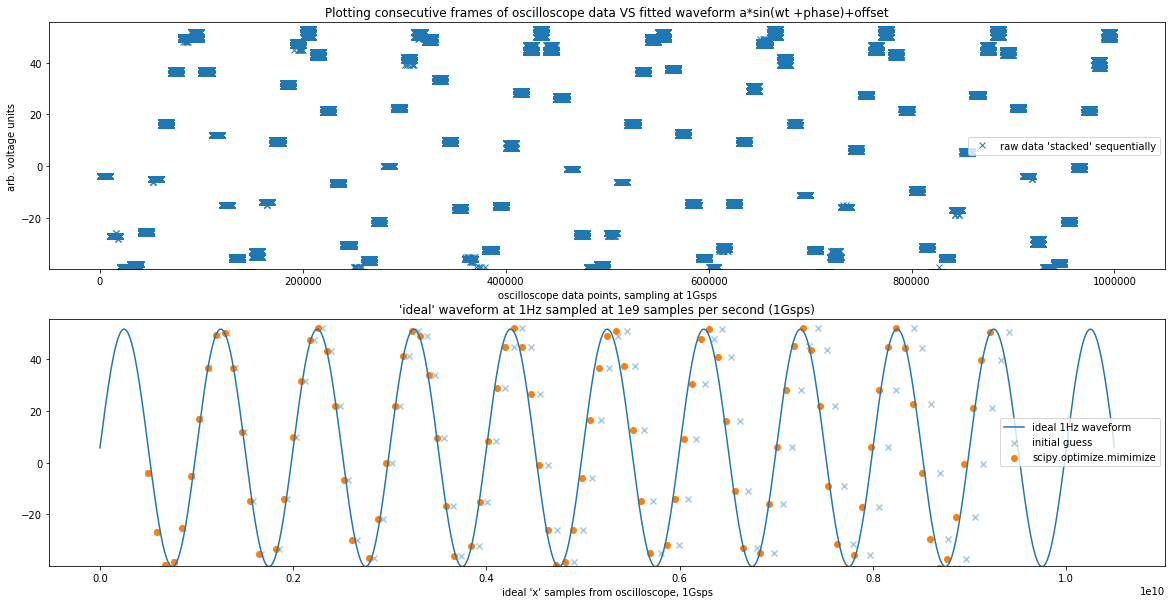

In [62]:
%%time
fig,axx = plt.subplots(2,1,figsize=(20,10),sharey=True)
axx[0].plot((np.asarray([i[0][:] for i in all_data["1chSin"][:]])).reshape(-1),"x",label="raw data 'stacked' sequentially");
axx[0].set_ylim(*ylim) 
axx[0].set_title("Plotting consecutive frames of oscilloscope data VS fitted waveform a*sin(wt +phase)+offset")
#axx[0].text(0,0,",  ".join([f"{f:.3g}" for f in popt]))
#axx[0].plot(x,fun(x,*(45,5e-5,2.9,5.7)),label="expected waveform (1Hertz)")
axx[0].legend(loc="center right")
axx[0].set_xlabel("oscilloscope data points, sampling at 1Gsps")
#axx[1].plot(average_data[:,0],average_data[:,1],"x",label="averaged data")
axx[0].set_ylabel("arb. voltage units")
idealx = np.arange(0,1e9*1.05e1,1e6)
idealy=popt[0]*np.sin(idealx*np.pi*2*1*1e-9)+popt[-1]
a,b,c,d = res.x 
idealy=c*np.sin(idealx*np.pi*2*1*1e-9)+d
ax=axx[1]
ax.plot(idealx,idealy,label="ideal 1Hz waveform")
ax.set_title("'ideal' waveform at 1Hz sampled at 1e9 samples per second (1Gsps)")
ax.scatter(np.arange(len(average_data[:,0]))*.9e8+average_data[:,0]+5e8,average_data[:,1],marker="x",label="initial guess",alpha=0.4)
ax.scatter(np.arange(len(average_data[:,0]))*res.x[0]+average_data[:,0]+res.x[1],average_data[:,1],label="scipy.optimize.mimimize")
ax.legend()
ax.set_xlabel("ideal 'x' samples from oscilloscope, 1Gsps")
plt.savefig("results04_idealfitting.png")

In [63]:
#1e-5 seconds = 1e4 points

In [64]:
#1 second = 1e9 points

In [65]:
1e-9*1e4

1e-05

In [66]:
### 9 peaks = 9 seconds
### 100 screenshots, each 1e-05 seconds
fraction_sampled = sample_period*1e4*100/9
print(f"percent sampled = {fraction_sampled*100}%")

percent sampled = 0.011111111111111112%


In [67]:
scope_settings = [d[:-2] for i,d in list(enumerate(data)) if i in [4,12,13,15,19]]
print(scope_settings)
trigger_level = float(data[4].split(",")[1])
vert_scale = float(data[12].split(",")[1])
vert_pos = float(data[13].split(",")[1])
trigger_level,vert_scale,vert_pos,np.max(raw_data),np.min(raw_data)

['Trigger Level,1.192E-01,Trigger Level,1.192E-01', 'Vertical Scale,2.000e-02,Vertical Scale,1.000e+00', 'Vertical Position,-5.120e-02,Vertical Position,2.000e-01', 'Horizontal Scale,5.000E-09,Horizontal Scale,5.000E-09', 'Sampling Period,2.000e-09,Sampling Period,2.000e-09']


(0.1192, 0.02, -0.0512, -30, -31)

## fit to zigzag function

In [68]:
def linear(x,a,b):
    return a*x+b
from scipy.stats import linregress

In [69]:
average_data = np.asarray([(len(i[0][:]),np.mean(i[0][:])) for i in all_data["1chSaw"][:]])
average_data[:,0]=np.cumsum(average_data[:,0])

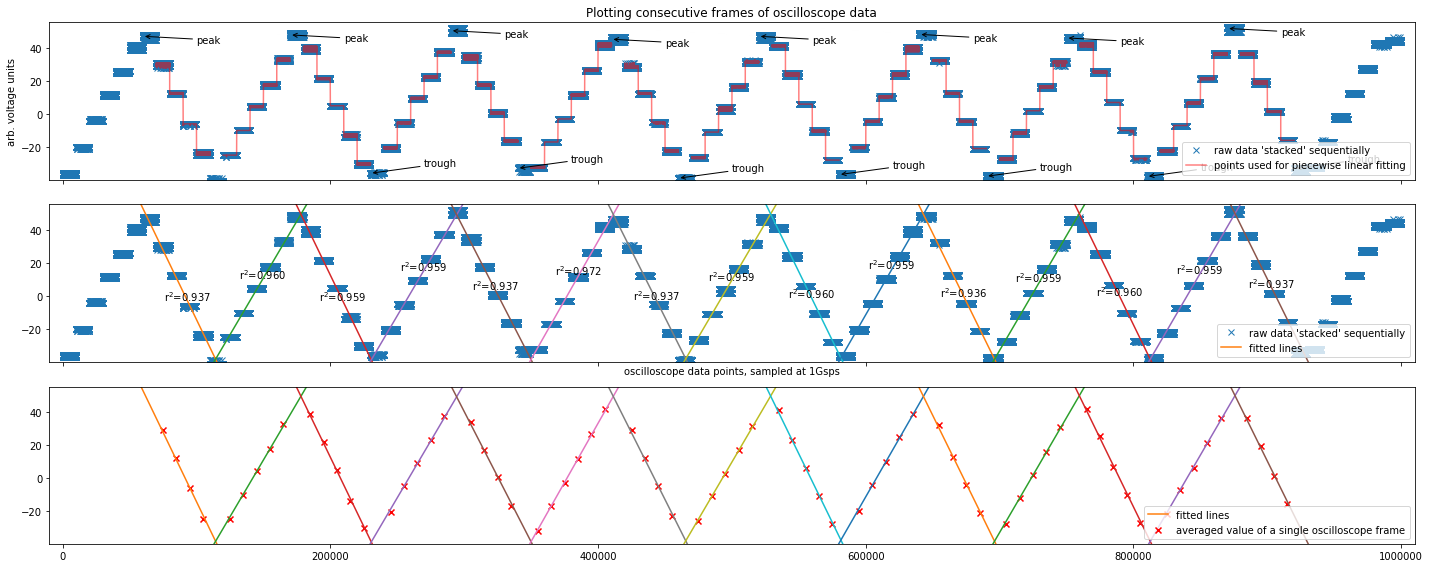

In [85]:
#plt.plot(average_data[:,0],average_data[:,1])

fig,axx = plt.subplots(3,1,figsize=(20,8),sharey=True,sharex=True)
rawdata = np.asarray([i[0][:] for i in all_data["1chSaw"][:]])
axx[0].plot(rawdata.reshape(-1),"x",label="raw data 'stacked' sequentially");
axx[1].plot(rawdata.reshape(-1),"x",alpha=1,label="raw data 'stacked' sequentially");
axx[2].plot(rawdata.reshape(-1)[1],alpha=0)
axx[0].set_ylim(*ylim)
axx[0].set_xlim(-len(rawdata.reshape(-1))*0.01,len(rawdata.reshape(-1))*1.01) 
axx[0].set_title("Plotting consecutive frames of oscilloscope data")
#axx[0].text(0,0,",  ".join([f"{f:.3g}" for f in popt]))
#axx[0].plot(x,fun(x,*(45,5e-5,2.9,5.7)),label="expected waveform (1Hertz)")

axx[1].set_xlabel("oscilloscope data points, sampled at 1Gsps")
#axx[1].plot(average_data[:,0],average_data[:,1],"x",label="averaged data")
axx[0].set_ylabel("arb. voltage units")
averageddata =np.asarray([np.mean(i[0][:]) for i in all_data["1chSaw"][:]])
peaks_bottoms = np.append([0],np.diff(np.sign(np.diff( averageddata))))
ax = axx[0]
sections_xy=[]
started= False
currstatus=0
tempsectionx=[];tempsectiony=[];tempfitting=[]
jitters=[]
for xval,(yval,status) in enumerate(zip(averageddata,peaks_bottoms)):
    #print(xval)
    if status != 0:
        ax.annotate("peak" if status==-2 else "trough",(xval*1e4,yval),(xval*1e4+4e4,yval+status*2),arrowprops={"arrowstyle":"->"})
    if status ==-2 and not started:
        started=True;currstatus=status;
    elif status != 0 and started:
        if status != currstatus:
            sections_xy.append((tempsectionx,tempsectiony,tempfitting))
            tempsectionx=[];tempsectiony=[];tempfitting=[]
            currstatus=status
    elif started:
        #print(xval)
        [tempsectionx.append( xval_+xval*1e4 ) for xval_ in range(10000)]
        [tempsectiony.append( yval_ ) for yval_ in rawdata[xval]]
        tempfitting.append( ([xval_+xval*1e4 for xval_ in range(10000)],rawdata[xval]) )
for i,(xdata,ydata,fittingvals) in enumerate(sections_xy):
    axx[0].plot(xdata,ydata,color="red",alpha=0.5,label="points used for piecewise linear fitting" if i==0 else"")
    slope, intercept, r_value, p_value, std_err = linregress(xdata, ydata)
    newxdata = np.arange(min(xdata)*0.8,max(xdata)*1.2,1e3)
    newydata = linear(np.asarray(newxdata),slope, intercept)
    axx[1].plot(np.asarray(newxdata),newydata,label="fitted lines" if i==0 else"")
    axx[2].plot(np.asarray(newxdata),newydata,label="fitted lines" if i==0 else"")
    axx[1].annotate(r"r$^2$"+f"={r_value**2:.3f}",(np.mean(newxdata),np.mean(newydata)), ha='center')#,arrowprops={"arrowstyle":"->"})
    #(np.mean(ydata)-intercept)/slope - np.mean(xdata)
    for ii,(fxdata,fydata) in enumerate(fittingvals):
        #print([np.mean(fxdata)],[np.mean(fydata)])
        jitters.append((np.mean(fydata)-intercept)/slope - np.mean(fxdata))
        axx[2].scatter(np.mean(fxdata),np.mean(fydata),c="red",marker="x",label="averaged value of a single oscilloscope frame" if i==0 and ii==0 else "")
    #print(slope)
axx[0].legend(loc="lower right")
axx[1].legend(loc="lower right")
axx[2].legend(loc="lower right")
plt.tight_layout()
plt.show()

Text(0.5, 0, 'error in x (1e-9 seconds)')

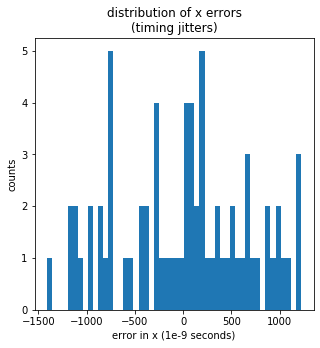

In [95]:
fig,axx=plt.subplots(1,1,figsize=(5,5))
ax=axx
ax.hist(jitters,bins=50,label);
ax.set_title("distribution of x errors\n(timing jitters)")
ax.set_ylabel("counts")
ax.set_xlabel("error in x (1e-9 seconds)")

## determine the uncertainty of x

$$y=mx+c, x=(y-c)/m$$

In [25]:
np.mean(xdata),np.mean(ydata)

(899999.5, 10.32355)